### Install gradcam

In [1]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.3 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=bb7b92f51b0613401839e1cbd27fe076e389419945b1ed

### Imports

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [22]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as TF
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt



### My CNN architecture

In [4]:
class MyImprovedCNN(nn.Module):
    def __init__(self, num_classes=257):
        super(MyImprovedCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 x 112 x 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128 x 56 x 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 256 x 28 x 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # 512 x 4 x 4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### Loading the model trained in task1_final-trained

In [5]:
model = MyImprovedCNN()
model.load_state_dict(torch.load("/kaggle/input/improvedcnn_onecycle/pytorch/default/1/best_model_onecycle.pth", map_location=device))
model.to(device)
model.eval()


MyImprovedCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

#### Target layer 
-24th in features, last conv layer_has features

In [6]:
target_layers = [model.features[24]]  # Last Conv 


### Data import, tranform and load


In [7]:
import os
data='/kaggle/input/caltech256/256_ObjectCategories'

In [8]:
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),                   #default for pretained is 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5520, 0.5336, 0.5050],       #normalise using calculated mean and std dev
                         std=[0.2353, 0.2345, 0.2372])
])


my_dataset = datasets.ImageFolder(root=data, transform=basic_transform)


In [9]:
my_loader = DataLoader(my_dataset, batch_size=1, shuffle=True)

### GradCam hooks


In [15]:
gradients = None
activations = None

def save_activation(module, input, output):
    global activations
    activations = output.detach()

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0].detach()

# register hooks on desired layer
target_layer = model.features[24]
target_layer.register_forward_hook(save_activation)
target_layer.register_full_backward_hook(save_gradient)


### GradCam helper functions

In [16]:
# caltech-256 normalization values (for denormalization)
mean = [0.5520, 0.5336, 0.5050]
std = [0.2353, 0.2345, 0.2372]

# undo normalization for image display
def denormalize(image):
    mean_inv = [-m for m in mean]
    std_inv = [1 / s for s in std]
    return TF.normalize(image, mean=mean_inv, std=std_inv)

# create grad-cam heatmap
def generate_grad_cam(image, model, class_id):
    model.zero_grad()
    output = model(image)
    score = output[0, class_id]
    score.backward()

    global gradients, activations

    # average gradients across width and height
    weights = torch.mean(gradients, dim=[0, 2, 3])

    # remove batch dim: [1, c, h, w] → [c, h, w]
    acts = activations.squeeze(0)

    # weigh activations by gradients
    for i in range(acts.shape[0]):
        acts[i] *= weights[i]

    # average over channels → [h, w]
    heatmap = acts.mean(dim=0).cpu()
    heatmap = np.maximum(heatmap, 0)

    # normalize to [0, 1]
    if torch.max(heatmap) != 0:
        heatmap /= torch.max(heatmap)

    return heatmap

# overlay heatmap on original image
def visualize_grad_cam(image, heatmap):
    image = image.squeeze(0).cpu()
    img = denormalize(image).numpy()
    img = np.transpose(img, (1, 2, 0))  # [c, h, w] → [h, w, c]
    img = np.clip(img, 0, 1)

    # resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))

    # apply color map
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

    # blend with original
    overlay = 0.4 * heatmap_color + 0.6 * img

    return img, heatmap_resized, overlay

### Random selection of 5 classes, 2 images per class

In [51]:
# select 5 random class indices
selected_classes = random.sample(range(256), 5)

# set images per class
images_per_class = 2

# init class-wise image storage
selected_images = {cls: [] for cls in selected_classes}

# collect images from dataloader
for image_batch, label_batch in my_loader:
    for i in range(len(image_batch)):
        class_id = label_batch[i].item()

        # check class and image count
        if class_id in selected_classes and len(selected_images[class_id]) < images_per_class:
            image_tensor = image_batch[i].unsqueeze(0).to(device)
            selected_images[class_id].append(image_tensor)

    # stop if all classes have enough images
    if all(len(imgs) >= images_per_class for imgs in selected_images.values()):
        break
print(selected_classes)

[177, 159, 132, 1, 76]


### Heatmap generated and overlayed


============================================ Grad-CAM for class 177 (178.school-bus) =============================================


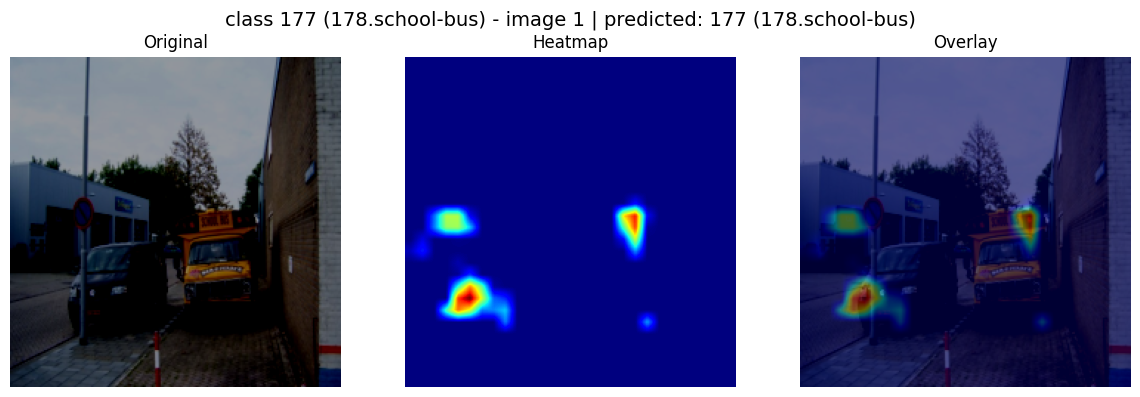

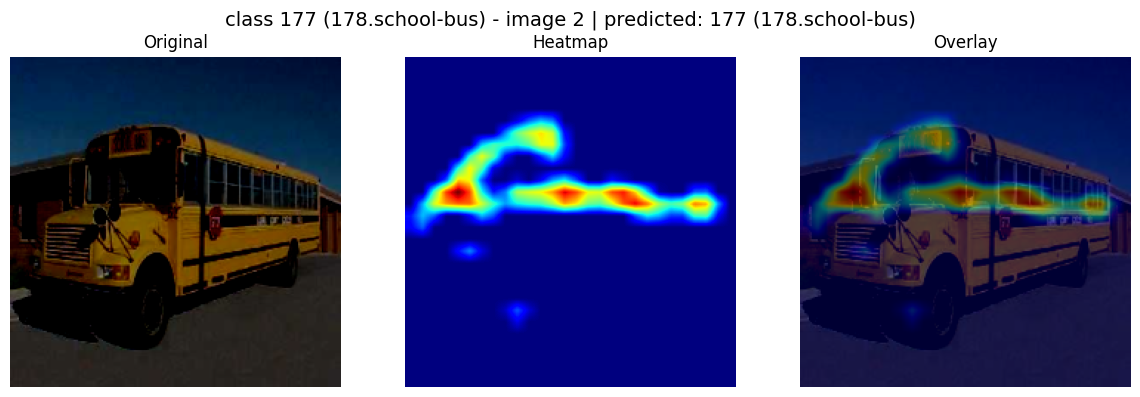


=========================================== Grad-CAM for class 159 (160.pez-dispenser) ===========================================


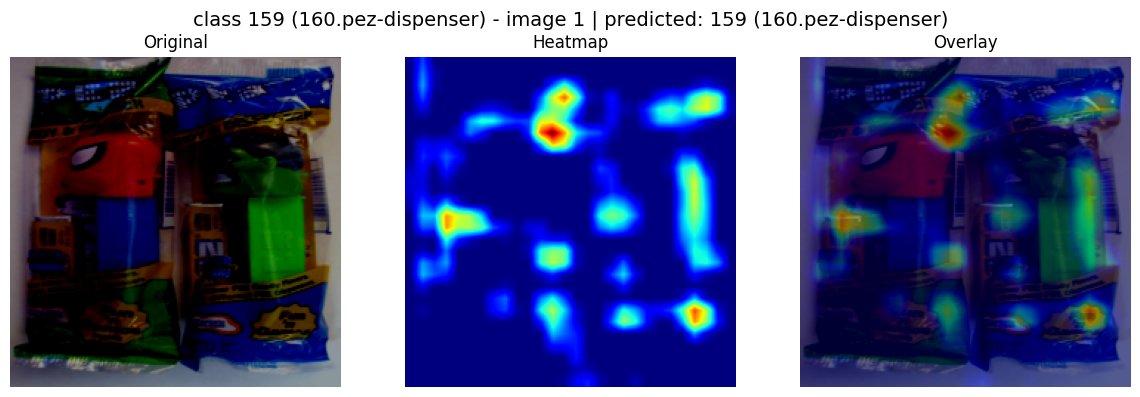

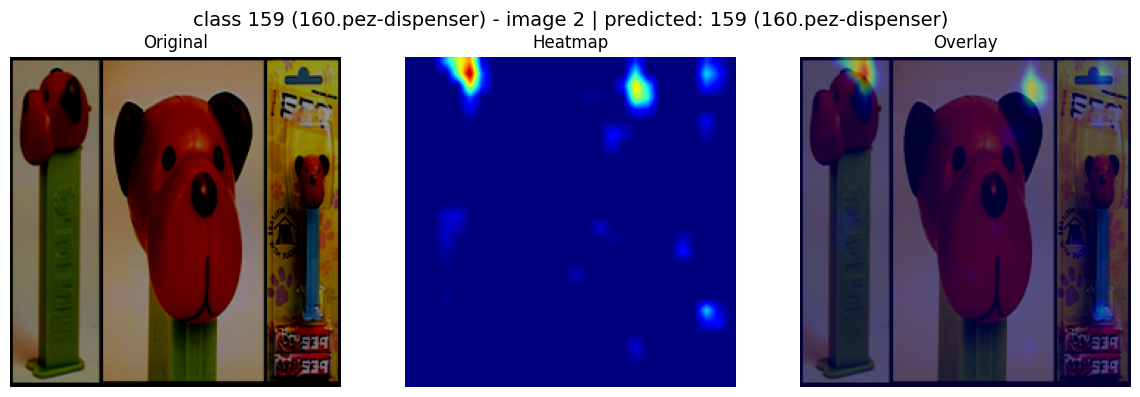


============================================= Grad-CAM for class 132 (133.lightning) =============================================


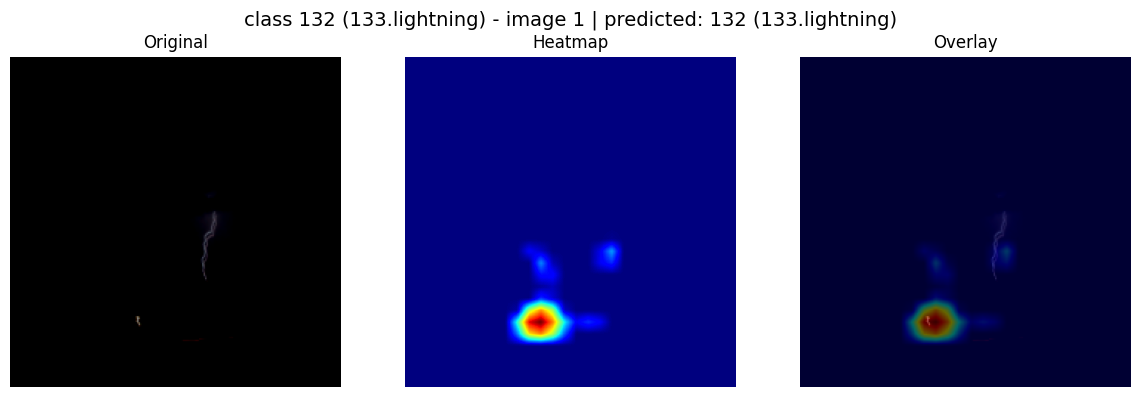

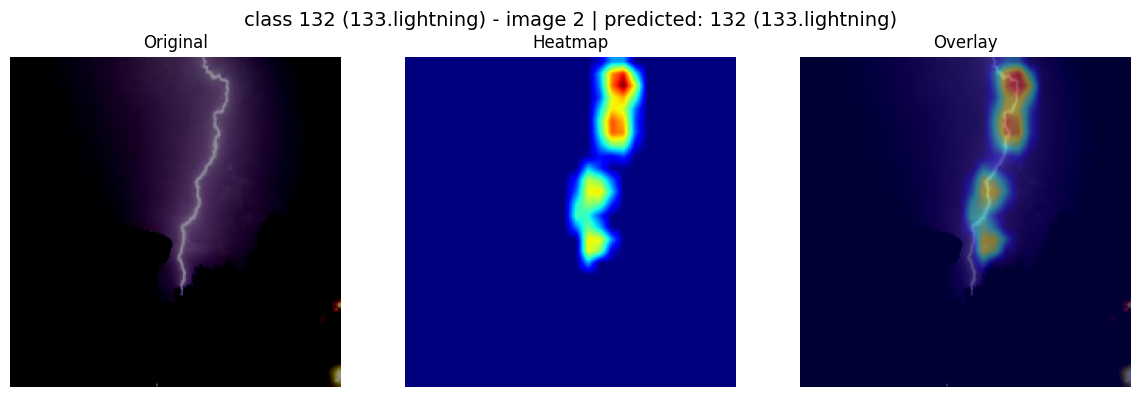


============================================ Grad-CAM for class 1 (002.american-flag) ============================================


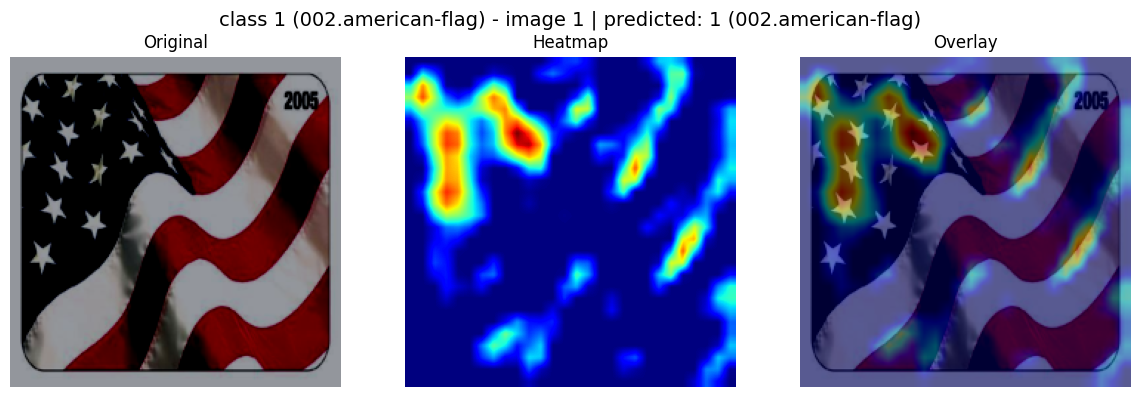

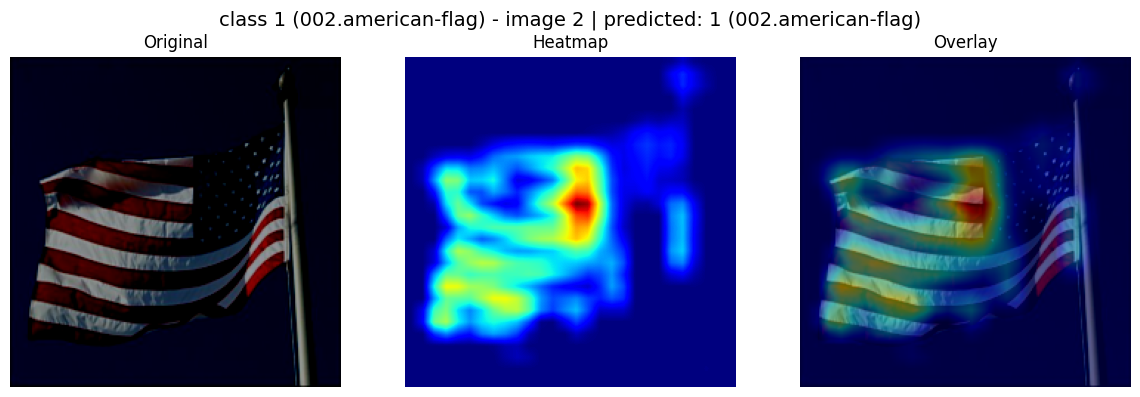


============================================ Grad-CAM for class 76 (077.french-horn) =============================================


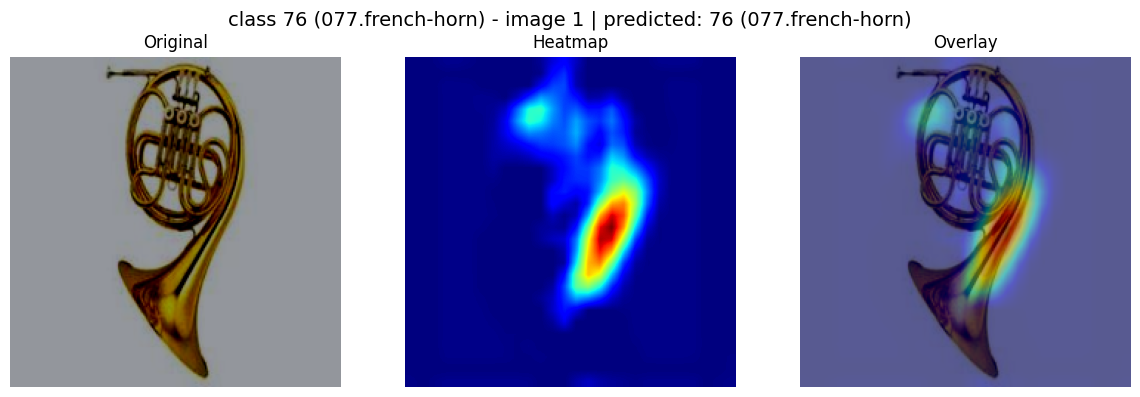

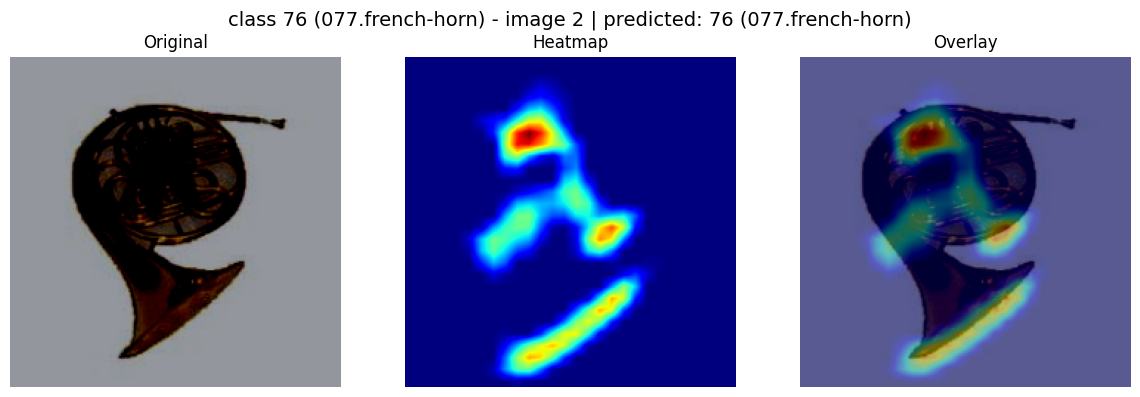

In [52]:
# mapping from index to label (folder name)
idx_to_label = {class_index: class_label for class_label, class_index in class_to_index.items()}

# loop over selected class indexes and their images
for class_idx, image_list in selected_images.items():
    class_label = idx_to_label[class_idx]  # get folder name like '003.backpack'
    title = f" Grad-CAM for class {class_idx} ({class_label}) "
    print(f"\n{'=' * 15}{title.center(100, '=')}{'=' * 15}")
    
  


    for i, image in enumerate(image_list):
        # get model prediction
        with torch.no_grad():
            output = model(image)
            predicted_class = output.argmax(dim=1).item()
            predicted_label = idx_to_label.get(predicted_class, "unknown")

        # generate grad-cam heatmap
        heatmap = generate_grad_cam(image, model, predicted_class)

        # overlay heatmap on original image
        original, heatmap_resized, overlay = visualize_grad_cam(image, heatmap)

        # plot results
        plt.figure(figsize=(12, 4))
        plt.suptitle(
            f"class {class_idx} ({class_label}) - image {i+1} | predicted: {predicted_class} ({predicted_label})",
            fontsize=14
        )

        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(original)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Heatmap")
        plt.imshow(heatmap_resized, cmap='jet')
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(overlay)
        plt.axis("off")

        plt.tight_layout()
        plt.show()


### Class labels and indexes

In [36]:
class_to_index = my_dataset.class_to_idx

index_to_class = {class_index: class_label for class_label, class_index in class_to_index.items()}

# print first 10 class index-label pairs
print("class index → class label:")
for class_index in sorted(index_to_class.keys())[:10]:
    print(f"{class_index:3} → {index_to_class[class_index]}")


class index → class label:
  0 → 001.ak47
  1 → 002.american-flag
  2 → 003.backpack
  3 → 004.baseball-bat
  4 → 005.baseball-glove
  5 → 006.basketball-hoop
  6 → 007.bat
  7 → 008.bathtub
  8 → 009.bear
  9 → 010.beer-mug
